In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

# The Basic Case

In [13]:
model = nengo.Network()

with model:
    
    
    sin = nengo.Node(lambda t: np.sin(t * 4))

    pre = nengo.Ensemble(50, 1)
    post = nengo.Ensemble(50, 1)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(
        pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)

    p_weights = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)
    p_spikes = nengo.Probe(post.neurons)
    p_out = nengo.Probe(post, synapse=0.01)

In [19]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

A Jupyter Widget

A Jupyter Widget

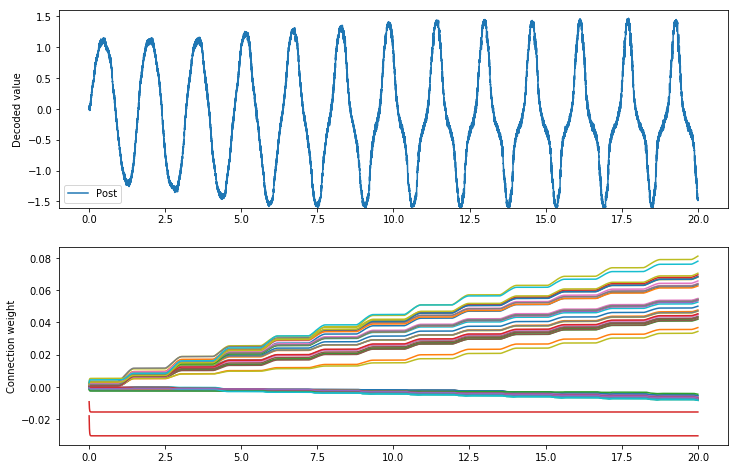

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[p_weights], axis=0), axis=1))
plt.plot(sim.trange(dt=0.01), sim.data[p_weights][..., neuron])
plt.ylabel("Connection weight");

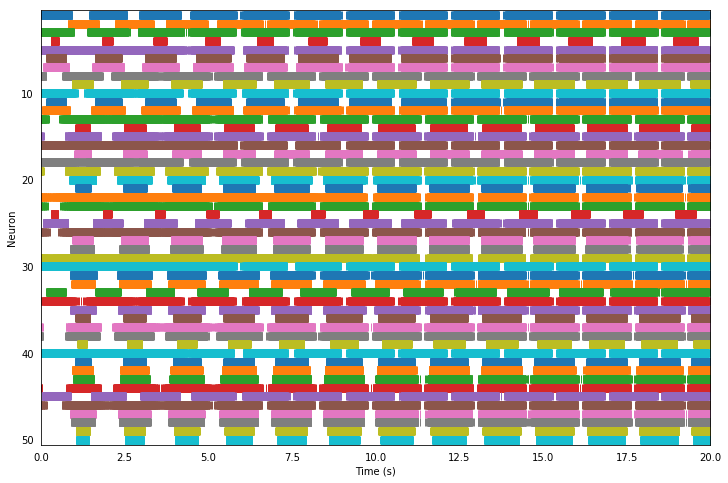

In [21]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1)
rasterplot(sim.trange(), sim.data[p_spikes], ax)
#ax.set_xlim(0, 1)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

# Reduced Case

In [16]:
import nengo

with nengo.Network() as model:
    def stim_func(t):
        if (t % 0.5) * 2 > 0.5:
            return 0.3
        else:
            return -0.3

    sin = nengo.Node(stim_func)

    pre = nengo.Ensemble(4, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[200, 250, 250, 200])
    post = nengo.Ensemble(2, 1, encoders=[[1], [-1]], intercepts=[-0.35, -0.35], max_rates=[300, 300])

    nengo.Connection(sin, pre)
    ww = 2*np.random.randn(pre.n_neurons, post.n_neurons) / post.n_neurons
    conn = nengo.Connection(
        pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)

    p_weights = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)
    p_wout = nengo.Probe(conn, synapse=0.01)
    pre_spikes = nengo.Probe(pre.neurons)
    post_spikes = nengo.Probe(post.neurons)
    p_out = nengo.Probe(post, synapse=0.01)

In [17]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

A Jupyter Widget

A Jupyter Widget

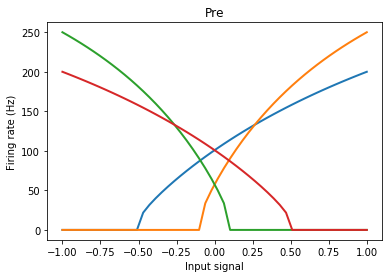

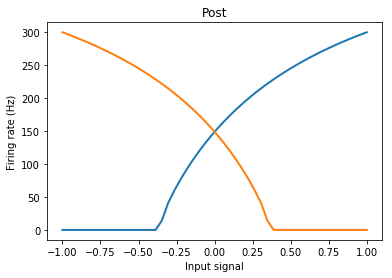

In [19]:
eval_points, activities = tuning_curves(pre, sim)

plt.figure()
plt.title("Pre")
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

eval_points, activities = tuning_curves(post, sim)

plt.figure()
plt.title("Post")
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

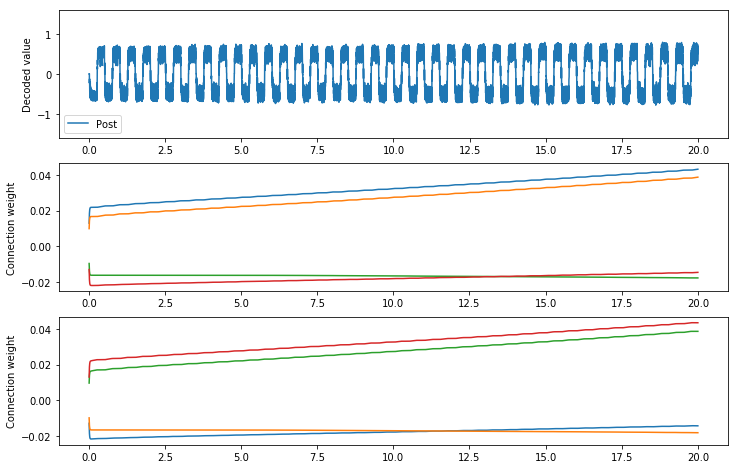

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(sim.trange(dt=0.01), sim.data[p_weights][:, 0])
plt.ylabel("Connection weight");
plt.subplot(3, 1, 3)
plt.plot(sim.trange(dt=0.01), sim.data[p_weights][:, -1])
plt.ylabel("Connection weight");

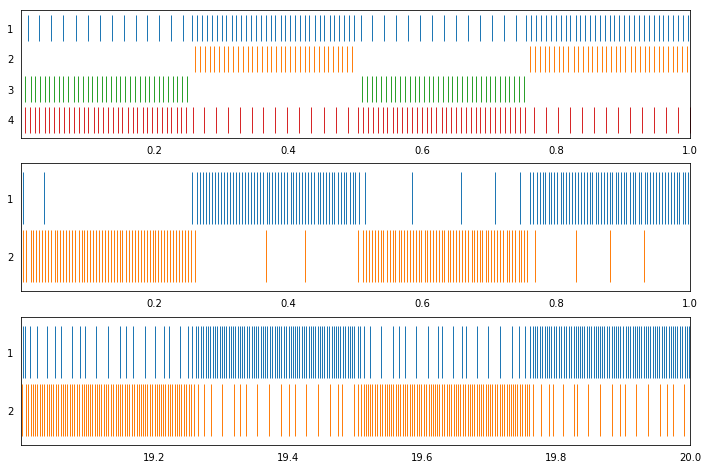

In [21]:
plt.figure(figsize=(12, 8))
win = 1000

ax = plt.subplot(3, 1, 1)
rasterplot(sim.trange()[:win], sim.data[pre_spikes][:win], ax)

ax = plt.subplot(3, 1, 2)
rasterplot(sim.trange()[:win], sim.data[post_spikes][:win], ax)

ax = plt.subplot(3, 1, 3)
rasterplot(sim.trange()[-win:], sim.data[post_spikes][-win:], ax)

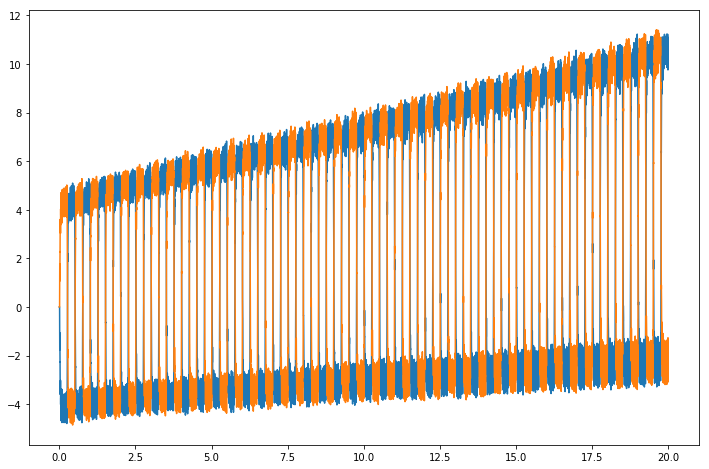

In [24]:
plt.figure(figsize=(12, 8))

plt.plot(sim.trange(), sim.data[p_wout])

# Pos Reduce Recurrent Case

In [143]:
model = nengo.Network()

with model:
    def stim_func(t):
        if (t % 1) > 0.5:
            return 0.3
        else:
            return -0.3
    # the stimulation type really doesn't make a difference
    stim = nengo.Node(lambda t: np.sin(t * 4))

    ens = nengo.Ensemble(4, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[250, 300, 300, 250])

    nengo.Connection(stim, ens)
    conn = nengo.Connection(
        ens.neurons, ens.neurons, transform=np.zeros((4, 4)),
        learning_rule_type=nengo.BCM(learning_rate=1e-10, theta_tau=1.5),
    )

    p_weights = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [144]:
with nengo.Simulator(model) as sim:
    sim.run(4)

A Jupyter Widget

A Jupyter Widget

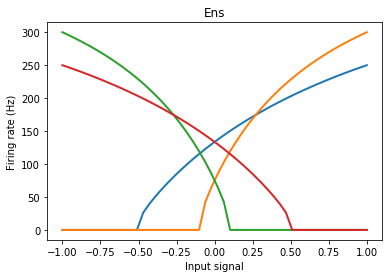

In [145]:
eval_points, activities = tuning_curves(ens, sim)

plt.figure()
plt.title("Ens")
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

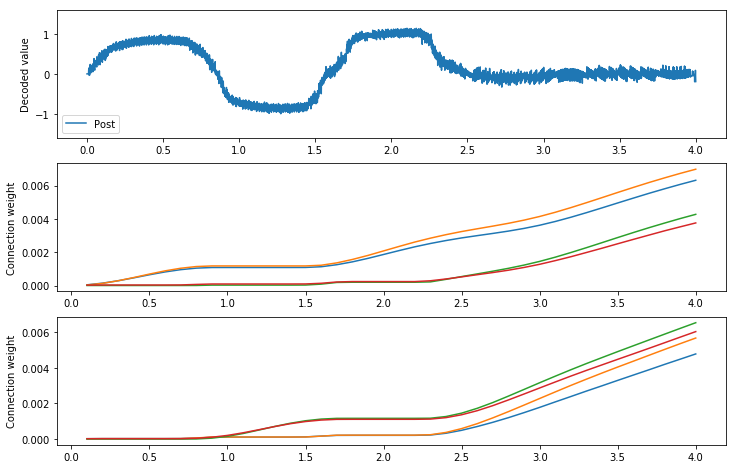

In [146]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, 0])
plt.ylabel("Connection weight");
plt.subplot(3, 1, 3)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, -1])
plt.ylabel("Connection weight");

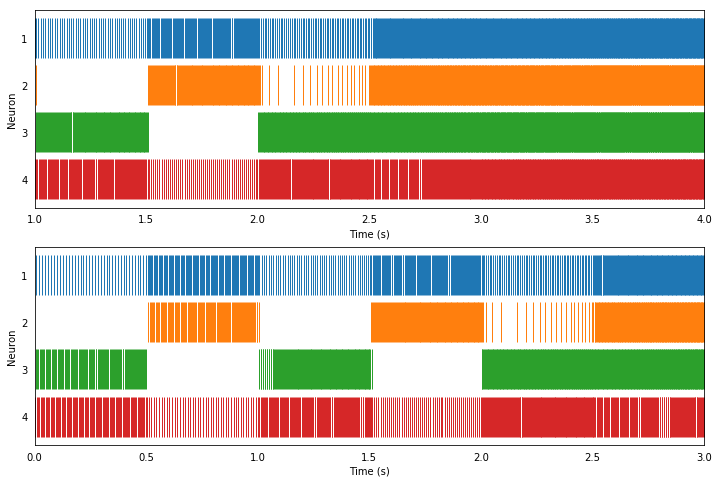

In [131]:
plt.figure(figsize=(12, 8))
win = int(3e3)

ax = plt.subplot(2, 1, 1)
rasterplot(sim.trange()[-win:], sim.data[p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

ax = plt.subplot(2, 1, 2)
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

# Neg Reduce Recurrent Case

In [82]:
from nengo_learn_assoc_mem.neg_bcm import NegBCM

In [103]:
model = nengo.Network()

with model:
    def stim_func(t):
        if (t % 1) > 0.5:
            return 0.3
        else:
            return -0.3

    stim = nengo.Node(stim_func)

    ens = nengo.Ensemble(4, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[250, 300, 300, 250])

    nengo.Connection(stim, ens)
    conn = nengo.Connection(
        ens.neurons, ens.neurons, transform=np.zeros((4, 4)),
        learning_rule_type=NegBCM(learning_rate=-5e-9, theta_tau=1.5),
    )

    p_weights = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [104]:
with nengo.Simulator(model) as sim:
    sim.run(10)

A Jupyter Widget

A Jupyter Widget

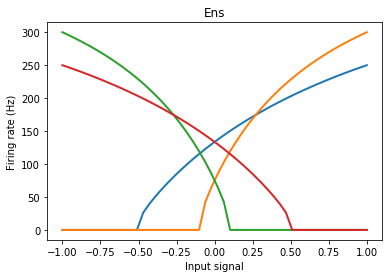

In [105]:
eval_points, activities = tuning_curves(ens, sim)

plt.figure()
plt.title("Ens")
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

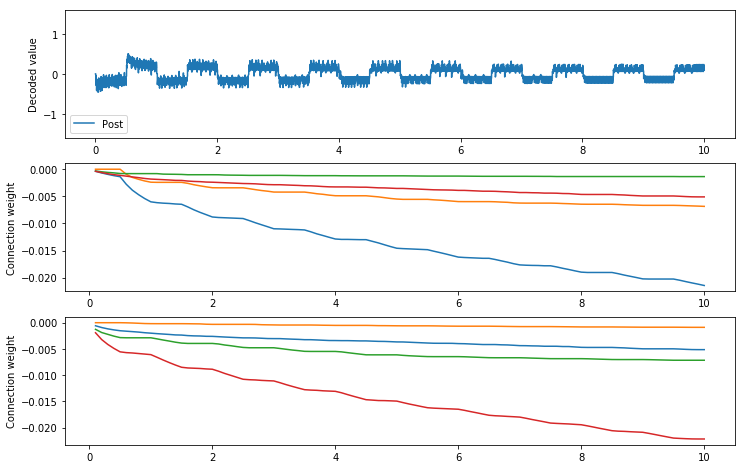

In [109]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, 0])
plt.ylabel("Connection weight");
plt.subplot(3, 1, 3)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, -1])
plt.ylabel("Connection weight");

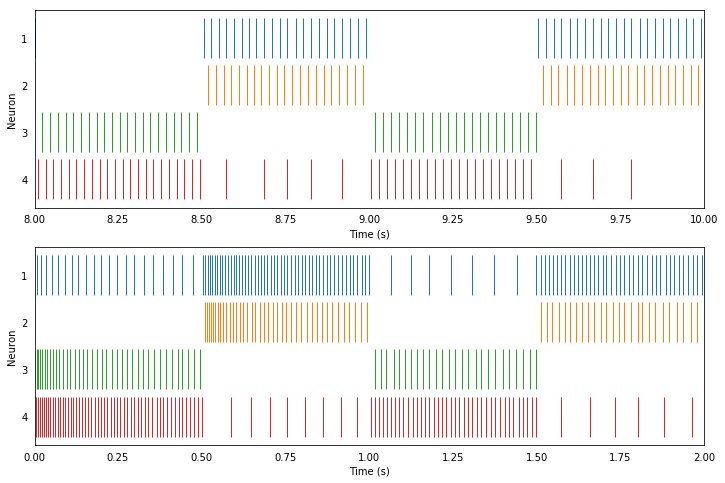

In [107]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(sim.trange()[-win:], sim.data[p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

ax = plt.subplot(2, 1, 2)
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

In [ ]:
plt.figure(figsize=(12, 8))

# filter this!
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

In [ ]:
# try the reduced case again, but with the prediction that some weights shouldn't react even if they're firing a little bit